## Document Similarity

In [1]:
!pip install nltk

In [2]:
import text_transformer

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Exercise 1:
Plot an histogram of the word vocabulary of “Alice in Wonderland”.
(number of words vs. frequency). (bins of size 1).

In [3]:
import nltk
nltk.download("gutenberg")
nltk.download("punkt")
alice = "carroll-alice.txt"
sents = nltk.corpus.gutenberg.sents(alice)

[nltk_data] Downloading package gutenberg to /home/jovyan/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Colect occurrences

In [4]:
flatten = list(text_transformer.flatten(sents))
size = len(flatten)
ocorrences = text_transformer.count_frequencies(flatten)

print("Tokens",size)
print("Distinct tokens",len(ocorrences))

Tokens 34113
Distinct tokens 3015


__Sort by occurrences__

In [5]:
ocorrences.sort(reverse=True, key=lambda token_count: token_count[1])

print("5 most frequent tokens",ocorrences[0:5])

5 most frequent tokens [(',', 1993), ("'", 1732), ('the', 1527), ('and', 802), ('.', 764)]


#### Make the the plot

In [6]:
import seaborn as sns

frequencies = [ token_count[1]/size for token_count in ocorrences]
sns.scatterplot(x=range(0,len(ocorrences)), y=frequencies, marker='+')

### Exercise 2: 
Then process the text: normalize, lemmatize, stop word removal, etc..
and plot the histogram again. (use nltk implementation). What happened? Describe
what changed in the frequency distribution of words.

#### Apply processing to tokens and collect occurrences

In [7]:
processed_tokens = text_transformer.normalizer(flatten)
processed_tokens = text_transformer.lemmatizer(processed_tokens) 
processed_ocorrences = text_transformer.count_frequencies(processed_tokens)


print("Tokens",len(processed_tokens))
print("Distinct tokens",len(processed_ocorrences))

Tokens 13946
Distinct tokens 2339


__Sort occurrences__

In [8]:
processed_ocorrences.sort(reverse=True, key=lambda token_count: token_count[1])
print("5 most frequent tokens",processed_ocorrences[0:5])

5 most frequent tokens [('i', 543), ('said', 462), ('alice', 398), ('little', 128), ('the', 115)]


#### Make the plot

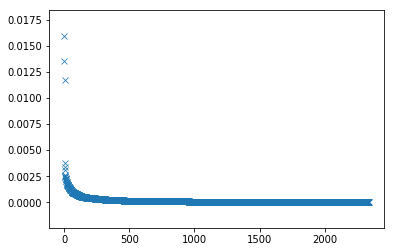

In [9]:
import seaborn as sns

processed_frequencies = [word[1]/size for word in processed_ocorrences]
sns.scatterplot(x=range(0,len(processed_ocorrences)), y=processed_frequencies, marker='x')

### Exercise 3:
Build the term-document matrix for the collection in “books”.Find the most similar document content to the “Alice in Wonderland” using tf-idf and cosine similarity.

In [10]:
import text_transformer as tt

In [11]:
books = ['shakespeare-macbeth.txt',
         'chesterton-ball.txt',
         'melville-moby_dick.txt',
         'austen-sense.txt',
         'carroll-alice.txt']

# inspired by https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3

In [12]:
book_list = {"macbeth": nltk.corpus.gutenberg.sents(books[0]),
             "ball": nltk.corpus.gutenberg.sents(books[1]),
             "moby_dick": nltk.corpus.gutenberg.sents(books[2]), 
             "sense": nltk.corpus.gutenberg.sents(books[3]),
             "alice":nltk.corpus.gutenberg.sents(books[4])}

In [13]:
for key, val in book_list.items():
    book_list[key] = list(tt.flatten(val))

In [14]:
for key, val in book_list.items():
    book_list[key] = tt.normalizer(val)

In [15]:
# the term frequency measures how often a term occurs in a document
# formula: simply count
def computeTF (word_dict):
    tfDict = {}
    for word, count in word_dict:
        tfDict[word] = count # <- the very very raw count

    return tfDict

In [16]:
# the IDF (inverted document frequency) is measuring the frequency a word exists in a document and invert this number
# formula: log(total number of documents/number of documents the word exist in)
def computeIDF (docDict):
    doclist = docDict.values() #transform the dict into a list
    import math
    idfDict = {}
    N = len(doclist) # get number of docs in collection
    
    for doc in doclist:
        for word in set(doc): #the set is necessary to get only distinct words from each document

            if word in idfDict:     # increment the count by one for each document 
                idfDict[word] += 1  # if the word hasn't been added to the dict yet, do
            else:
                idfDict[word] = 1

    for word, val in idfDict.items():
        idfDict[word] = math.log10(N/float(val)) #  <- magic formula
    
    return idfDict

In [17]:
# formula: (1+ log(TF)) * IDF
def computeTFIDF(tfDict, idfDict):
    import math
    tfidf = {}
    for word, val in tfDict.items():
        tfidf[word] = (1 + math.log(val))*idfDict[word]
        
    return tfidf

In [18]:
alice_freq = tt.count_frequencies(book_list["alice"])

In [19]:
alice_TF = computeTF(alice_freq)

In [20]:
IDF = computeIDF(book_list)

In [21]:
alice_TFIDF = computeTFIDF(alice_TF, IDF)

### Cosine Similarity

In [28]:
import pandas as pd
import numpy as np
import math

In [25]:
for i, book in enumerate(book_list):
    if i == 0:
        df = pd.DataFrame(tt.count_frequencies(book_list[book])).set_index(0)
        df.columns = [book]
    else:
        temp_df = pd.DataFrame(tt.count_frequencies(book_list[book])).set_index(0)
        temp_df.columns = [book]
        df = df.join(temp_df)

In [29]:
cosine = df.applymap(math.log10)

In [30]:
cosine = cosine.fillna(0)

In [31]:
cosine_exp = cosine.applymap(lambda x: x**2)

In [32]:
sum_list = cosine_exp.sum(axis=0)

In [33]:
sum_list = np.sqrt(sum_list)

In [34]:
cosine_length = cosine/sum_list

In [40]:
cosine.head()

In [41]:
similarities = pd.DataFrame(columns = book_list.keys())
for book in book_list:
    temp = []
    for another_book in book_list:
        temp.append((cosine_length[book] * cosine_length[another_book]).sum())
    similarities.loc[book] = temp

In [42]:
similarities

,macbeth,ball,moby_dick,sense,alice
macbeth,1.000000,0.601144,0.620574,0.575267,0.534295
ball,0.601144,1.000000,0.860933,0.814500,0.800858
moby_dick,0.620574,0.860933,1.000000,0.798431,0.722317
sense,0.575267,0.814500,0.798431,1.000000,0.742270
alice,0.534295,0.800858,0.722317,0.742270,1.000000


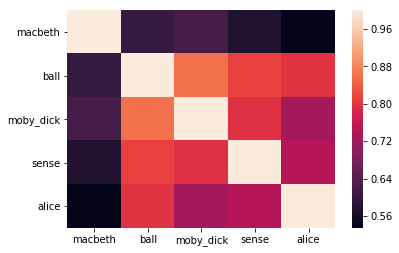

In [43]:
import seaborn as sns
sns.heatmap(similarities)